# Predicting Credit Default

In [25]:
import pandas as pd

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler #OneHotEncoder,
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import xgboost as xgb
import matplotlib.pyplot as plt
import eli5

In [26]:
seed = 1234

In [27]:
# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

col_names = names = ["checking_account", "duration", "credit_history", "purpose", "credit_amount", 
                     "savings", "employment_since", "installment_rate", "status", "debtors_guarantors", 
                     "residence", "property", "age", "other_installments", "housing", 
                     "credits", "job", "dependents", "telephone", "foreign_worker", "credit"]

data_df = pd.read_csv("german.data",names = col_names, delimiter=' ')
data_df.head()

,checking_account,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,status,debtors_guarantors,...,property,age,other_installments,housing,credits,job,dependents,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## Feature engineering

In [28]:
# Remap the target attribute: 1 - good credit, 0 - bad credit
data_df["credit"].replace([1,2], [1,0], inplace=True)

In [29]:
num_attr_names = ["duration", "credit_amount", "installment_rate", "residence", 
                  "age", "credits", "dependents"]

cat_attr_names = ["checking_account", "credit_history", "purpose", "savings", "employment_since", 
                  "status", "debtors_guarantors", "property", "other_installments", "housing", 
                  "job", "telephone", "foreign_worker"]

num_attr_norm = pd.DataFrame(StandardScaler().fit_transform(data_df[num_attr_names]),
                             columns=num_attr_names)

num_attr_norm.head()

,duration,credit_amount,installment_rate,residence,age,credits,dependents
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869


In [30]:
dd = defaultdict(LabelEncoder)

cat_attr = data_df[cat_attr_names].apply(lambda col: dd[col.name].fit_transform(col))

cat_attr_dummy = pd.get_dummies(data_df[cat_attr_names])

cat_attr_dummy.head()

,checking_account_A11,checking_account_A12,checking_account_A13,checking_account_A14,credit_history_A30,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,purpose_A40,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
2,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,1,0,1,0,1,0


In [31]:
clean_df = pd.concat([cat_attr_dummy, num_attr_norm, data_df["credit"]], axis = 1)
clean_df.head()

,checking_account_A11,checking_account_A12,checking_account_A13,checking_account_A14,credit_history_A30,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,purpose_A40,...,foreign_worker_A201,foreign_worker_A202,duration,credit_amount,installment_rate,residence,age,credits,dependents,credit
0,1,0,0,0,0,0,0,0,1,0,...,1,0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,1
1,0,1,0,0,0,0,1,0,0,0,...,1,0,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0
2,0,0,0,1,0,0,0,0,1,0,...,1,0,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,1
3,1,0,0,0,0,0,1,0,0,0,...,1,0,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,1
4,1,0,0,0,0,0,0,1,0,1,...,1,0,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0


In [32]:
X = clean_df.loc[:, clean_df.columns != "credit"]
y = clean_df["credit"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [34]:
y_train.value_counts()

1    570
0    230
Name: credit, dtype: int64

In [35]:
oversample = SMOTE(random_state=seed)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [36]:
y_train.value_counts()

1    570
0    570
Name: credit, dtype: int64

## Model training

In [37]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective="binary:logistic", random_state=seed)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [38]:
y_pred = xgc.predict(X_test)

In [39]:
print("Accuracy: %.2f" % accuracy_score(y_pred, y_test))
print("F1 score: %.2f" % f1_score(y_pred, y_test))

Accuracy: 0.71
F1 score: 0.80


## Feature importance

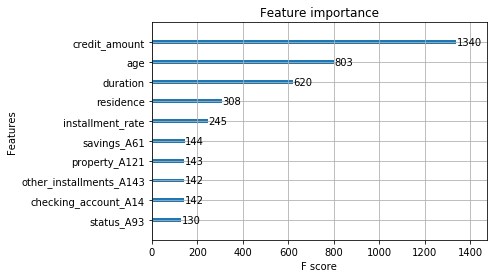

In [40]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10)

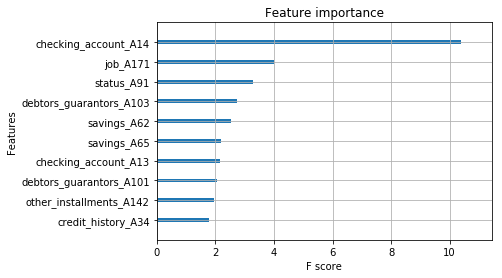

In [41]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False)

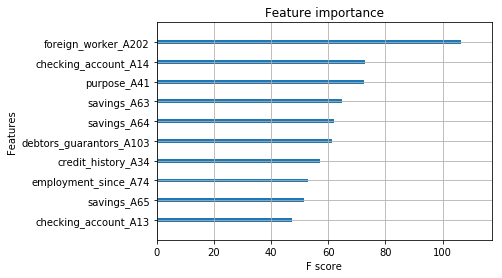

In [42]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False)

## ELI5

In [43]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.1347,checking_account_A14
0.0519,job_A171
0.0424,status_A91
0.0353,debtors_guarantors_A103
0.0327,savings_A62
0.0286,savings_A65
0.0279,checking_account_A13
0.0266,debtors_guarantors_A101
0.0251,other_installments_A142
0.0232,credit_history_A34


In [45]:
id = 0
#id = 16
print("Actual Label: %s" % y_test.iloc[id])
print("Predicted: %s" % y_pred[id])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[id], 
                     feature_names=list(X.columns),
                     show_feature_values=True)

Actual Label: 1
Predicted: 1


## Skater

In [46]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test, training_labels=y_test, 
                             feature_names=list(X.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
                         target_names=["bad credit","good credit"])

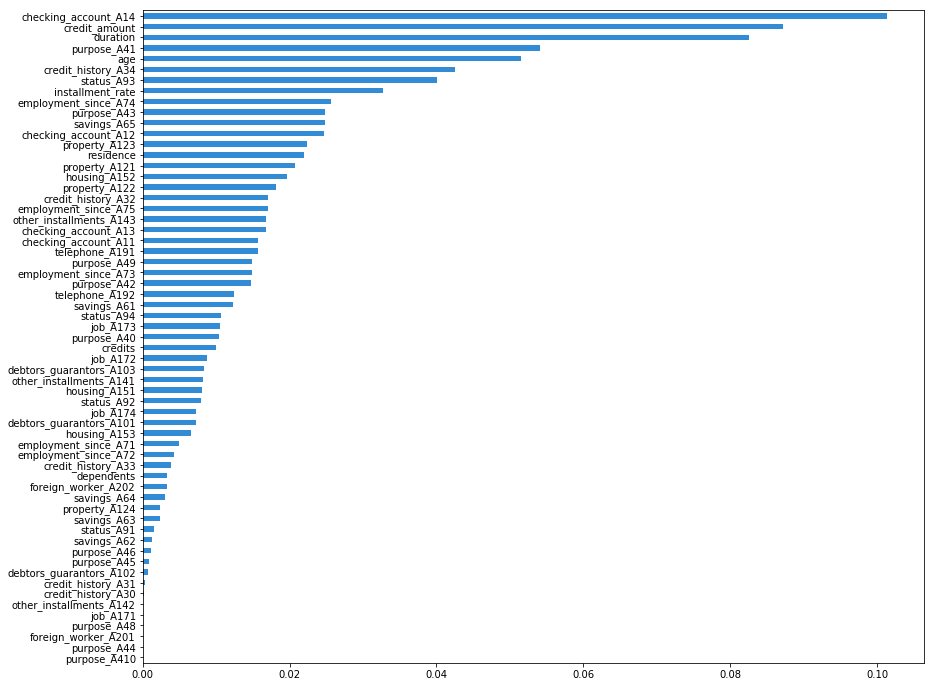

In [47]:
fig, ax = plt.subplots(figsize=(14,12))
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, ax=ax, progressbar=False)

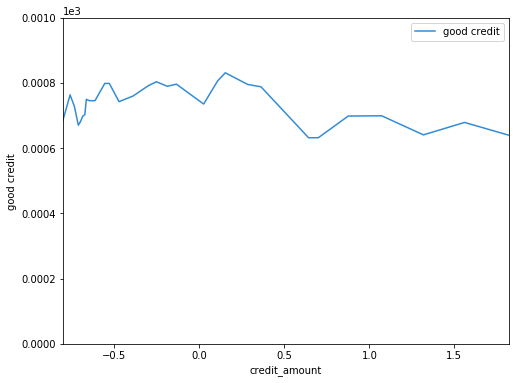

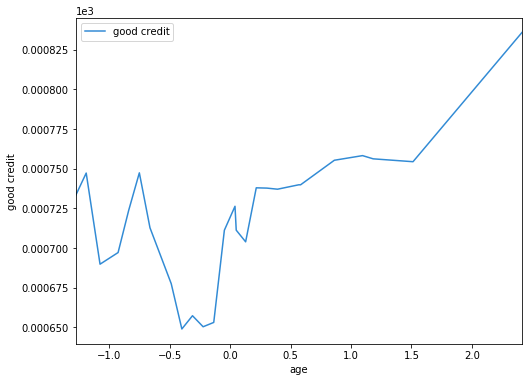

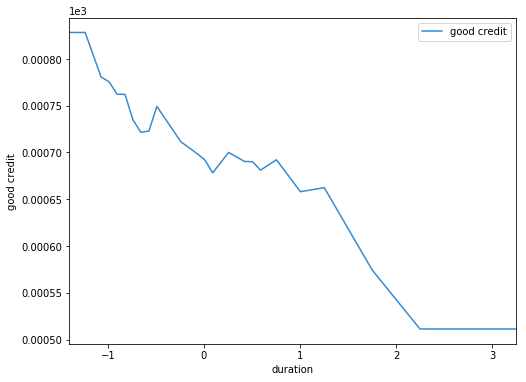

In [48]:
r = interpreter.partial_dependence.plot_partial_dependence(["credit_amount", "age", "duration"], im_model, progressbar=False, figsize = (8, 6))
yl = r[0][1].set_ylim(0, 1) 

[810/810] grid cells ████████████████████ Time elapsed: 426 seconds

[[<Figure size 864x720 with 2 Axes>,

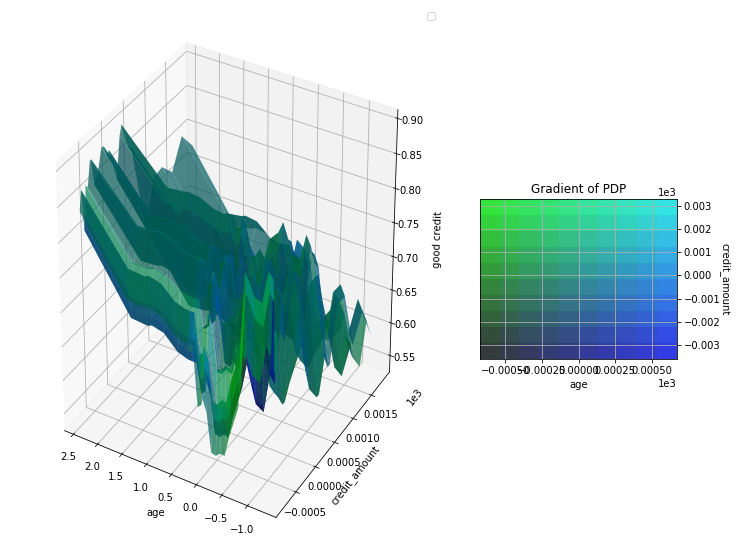

In [24]:
interpreter.partial_dependence.plot_partial_dependence([("age", "credit_amount")], 
                                                                    im_model, 
                                                                    figsize=(12, 10),
                                                                    grid_resolution=30)